# Wright-Fisher model of mutation, selection and random genetic drift

A Wright-Fisher model has a fixed population size *N* and discrete non-overlapping generations. Each generation, each individual has a random number of offspring whose mean is proportional to the individual's fitness. Each generation, mutation may occur. Mutations may increase or decrease individual's fitness, which affects the chances of that individual's offspring in subsequent generations.

Here, I'm using a fitness model where some proportion of the time a mutation will have a fixed fitness effect, increasing or decreasing fitness by a fixed amount.

## Setup

In [84]:
import numpy as np
import itertools

## Make population dynamic model

### Basic parameters

In [85]:
pop_size = 100

In [86]:
seq_length = 10

In [87]:
alphabet = ['A', 'T']

In [88]:
base_haplotype = "AAAAAAAAAA"

In [89]:
fitness_effect = 1.1 # fitness effect if a functional mutation occurs

In [90]:
fitness_chance = 0.1 # chance that a mutation has a fitness effect

### Population of haplotypes maps to counts and fitnesses

Store this as a lightweight Dictionary that maps a string to a count. All the sequences together will have count *N*.

In [91]:
pop = {}

In [92]:
pop["AAAAAAAAAA"] = 40

In [93]:
pop["AAATAAAAAA"] = 30

In [94]:
pop["AATTTAAAAA"] = 30

*Map haplotype string to fitness float.*

In [95]:
fitness = {}

In [96]:
fitness["AAAAAAAAAA"] = 1.0

In [97]:
fitness["AAATAAAAAA"] = 1.05

In [98]:
fitness["AATTTAAAAA"] = 1.10

In [99]:
pop["AAATAAAAAA"]

30

In [100]:
fitness["AAATAAAAAA"]

1.05

### Add mutation

In [101]:
mutation_rate = 0.005 # per gen per individual per site

In [102]:
def get_mutation_count():
    mean = mutation_rate * pop_size * seq_length
    return np.random.poisson(mean)

In [103]:
def get_random_haplotype():
    haplotypes = pop.keys() 
    frequencies = [x/float(pop_size) for x in pop.values()]
    return np.random.choice(haplotypes, p=frequencies)

In [104]:
def get_mutant(haplotype):
    site = np.random.randint(seq_length)
    possible_mutations = list(alphabet)
    possible_mutations.remove(haplotype[site])
    mutation = np.random.choice(possible_mutations)
    new_haplotype = haplotype[:site] + mutation + haplotype[site+1:]
    return new_haplotype

*Mutations have fitness effects*

In [105]:
def get_fitness(haplotype):
    old_fitness = fitness[haplotype]
    if (np.random.random() < fitness_chance):
        return old_fitness * fitness_effect
    else:
        return old_fitness

In [106]:
get_fitness("AAAAAAAAAA")

1.0

*If a mutation event creates a new haplotype, assign it a random fitness.*

In [107]:
def mutation_event():
    haplotype = get_random_haplotype()
    if pop[haplotype] > 1:
        pop[haplotype] -= 1
        new_haplotype = get_mutant(haplotype)
        if new_haplotype in pop:
            pop[new_haplotype] += 1
        else:
            pop[new_haplotype] = 1
        if new_haplotype not in fitness:
            fitness[new_haplotype] = get_fitness(haplotype)

In [108]:
mutation_event()

In [109]:
pop

{'AAAAAAAAAA': 39, 'AAATAAAAAA': 30, 'AATTTAAAAA': 30, 'ATAAAAAAAA': 1}

In [110]:
fitness

{'AAAAAAAAAA': 1.0, 'AAATAAAAAA': 1.05, 'AATTTAAAAA': 1.1, 'ATAAAAAAAA': 1.0}

In [111]:
def mutation_step():
    mutation_count = get_mutation_count()
    for i in range(mutation_count):
        mutation_event()

### Genetic drift and fitness affect which haplotypes make it to the next generation

*Fitness weights the multinomial draw.*

In [112]:
def get_offspring_counts():
    haplotypes = pop.keys()
    frequencies = [pop[haplotype]/float(pop_size) for haplotype in haplotypes]
    fitnesses = [fitness[haplotype] for haplotype in haplotypes]
    weights = [x * y for x,y in zip(frequencies, fitnesses)]
    total = sum(weights)
    weights = [x / total for x in weights]
    return list(np.random.multinomial(pop_size, weights))

In [113]:
get_offspring_counts()

[39, 29, 2, 30]

In [114]:
def offspring_step():
    counts = get_offspring_counts()
    for (haplotype, count) in zip(pop.keys(), counts):
        if (count > 0):
            pop[haplotype] = count
        else:
            del pop[haplotype]

### Combine and iterate

In [115]:
def time_step():
    mutation_step()
    offspring_step()

In [116]:
generations = 5

In [117]:
def simulate():
    for i in range(generations):
        time_step()

### Record

We want to keep a record of past population frequencies to understand dynamics through time. At each step in the simulation, we append to a history object.

In [118]:
history = []

In [119]:
def simulate():
    clone_pop = dict(pop)
    history.append(clone_pop)
    for i in range(generations):
        time_step()
        clone_pop = dict(pop)
        history.append(clone_pop)

In [120]:
simulate()

## Analyze trajectories

### Calculate diversity

In [121]:
def get_distance(seq_a, seq_b):
    diffs = 0
    length = len(seq_a)
    assert len(seq_a) == len(seq_b)
    for chr_a, chr_b in zip(seq_a, seq_b):
        if chr_a != chr_b:
            diffs += 1
    return diffs / float(length)

In [122]:
def get_diversity(population):
    haplotypes = population.keys()
    haplotype_count = len(haplotypes)
    diversity = 0
    for i in range(haplotype_count):
        for j in range(haplotype_count):
            haplotype_a = haplotypes[i]
            haplotype_b = haplotypes[j]
            frequency_a = population[haplotype_a] / float(pop_size)
            frequency_b = population[haplotype_b] / float(pop_size)
            frequency_pair = frequency_a * frequency_b
            diversity += frequency_pair * get_distance(haplotype_a, haplotype_b)
    return diversity

In [123]:
def get_diversity_trajectory():
    trajectory = [get_diversity(generation) for generation in history]
    return trajectory

### Plot diversity

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

In [125]:
def diversity_plot():
    mpl.rcParams['font.size']=14
    trajectory = get_diversity_trajectory()
    plt.plot(trajectory)    
    plt.ylabel("diversity")
    plt.xlabel("generation")

### Analyze and plot divergence

In [126]:
def get_divergence(population):
    haplotypes = population.keys()
    divergence = 0
    for haplotype in haplotypes:
        frequency = population[haplotype] / float(pop_size)
        divergence += frequency * get_distance(base_haplotype, haplotype)
    return divergence

In [127]:
def get_divergence_trajectory():
    trajectory = [get_divergence(generation) for generation in history]
    return trajectory

In [128]:
def divergence_plot():
    mpl.rcParams['font.size']=14
    trajectory = get_divergence_trajectory()
    plt.plot(trajectory)
    plt.ylabel("divergence")
    plt.xlabel("generation") 

### Plot haplotype trajectories

In [129]:
def get_frequency(haplotype, generation):
    pop_at_generation = history[generation]
    if haplotype in pop_at_generation:
        return pop_at_generation[haplotype]/float(pop_size)
    else:
        return 0

In [130]:
def get_trajectory(haplotype):
    trajectory = [get_frequency(haplotype, gen) for gen in range(generations)]
    return trajectory

In [131]:
def get_all_haplotypes():
    haplotypes = set()   
    for generation in history:
        for haplotype in generation:
            haplotypes.add(haplotype)
    return haplotypes

In [132]:
colors = ["#781C86", "#571EA2", "#462EB9", "#3F47C9", "#3F63CF", "#447CCD", "#4C90C0", "#56A0AE", "#63AC9A", "#72B485", "#83BA70", "#96BD60", "#AABD52", "#BDBB48", "#CEB541", "#DCAB3C", "#E49938", "#E68133", "#E4632E", "#DF4327", "#DB2122"]

In [133]:
colors_lighter = ["#A567AF", "#8F69C1", "#8474D1", "#7F85DB", "#7F97DF", "#82A8DD", "#88B5D5", "#8FC0C9", "#97C8BC", "#A1CDAD", "#ACD1A0", "#B9D395", "#C6D38C", "#D3D285", "#DECE81", "#E8C77D", "#EDBB7A", "#EEAB77", "#ED9773", "#EA816F", "#E76B6B"]

In [134]:
def stacked_trajectory_plot():
    mpl.rcParams['font.size']=18
    haplotypes = get_all_haplotypes()
    trajectories = [get_trajectory(haplotype) for haplotype in haplotypes]
    plt.stackplot(range(generations), trajectories, colors=colors_lighter)
    plt.ylim(0, 1)
    plt.ylabel("frequency")
    plt.xlabel("generation")

### Plot SNP trajectories

In [135]:
def get_snp_frequency(site, generation):
    minor_allele_frequency = 0.0
    pop_at_generation = history[generation]
    for haplotype in pop_at_generation.keys():
        allele = haplotype[site]
        frequency = pop_at_generation[haplotype] / float(pop_size)
        if allele != "A":
            minor_allele_frequency += frequency
    return minor_allele_frequency

In [136]:
get_snp_frequency(3, 5)

0.67999999999999994

In [137]:
def get_snp_trajectory(site):
    trajectory = [get_snp_frequency(site, gen) for gen in range(generations)]
    return trajectory

In [138]:
get_snp_trajectory(3)

[0.6, 0.67000000000000004, 0.75, 0.62000000000000011, 0.60000000000000009]

Find all variable sites.

In [139]:
def get_all_snps():
    snps = set()   
    for generation in history:
        for haplotype in generation:
            for site in range(seq_length):
                if haplotype[site] != "A":
                    snps.add(site)
    return snps

In [140]:
def snp_trajectory_plot():
    mpl.rcParams['font.size']=18
    snps = get_all_snps()
    trajectories = [get_snp_trajectory(snp) for snp in snps]
    data = []
    for trajectory, color in itertools.izip(trajectories, itertools.cycle(colors)):
        data.append(range(generations))
        data.append(trajectory)    
        data.append(color)
    fig = plt.plot(*data)   
    plt.ylim(0, 1)
    plt.ylabel("frequency")
    plt.xlabel("generation")

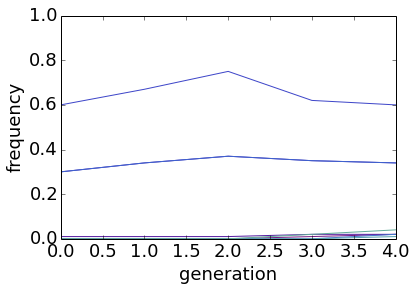

In [141]:
snp_trajectory_plot()

## Scale up

Here, we scale up to more interesting parameter values.

In [148]:
pop_size = 50
seq_length = 100
generations = 500
mutation_rate = 0.0001 # per gen per individual per site
fitness_effect = 1.1 # fitness effect if a functional mutation occurs
fitness_chance = 0.1 # chance that a mutation has a fitness effect

In this case there are $\mu$ = 0.01 mutations entering the population every generation.

In [149]:
seq_length * mutation_rate

0.01

And the population genetic parameter $\theta$, which equals $2N\mu$, is 1.

In [150]:
2 * pop_size * seq_length * mutation_rate

1.0

In [151]:
base_haplotype = ''.join(["A" for i in range(seq_length)])
pop.clear()
fitness.clear()
del history[:]
pop[base_haplotype] = pop_size
fitness[base_haplotype] = 1.0

In [152]:
simulate()

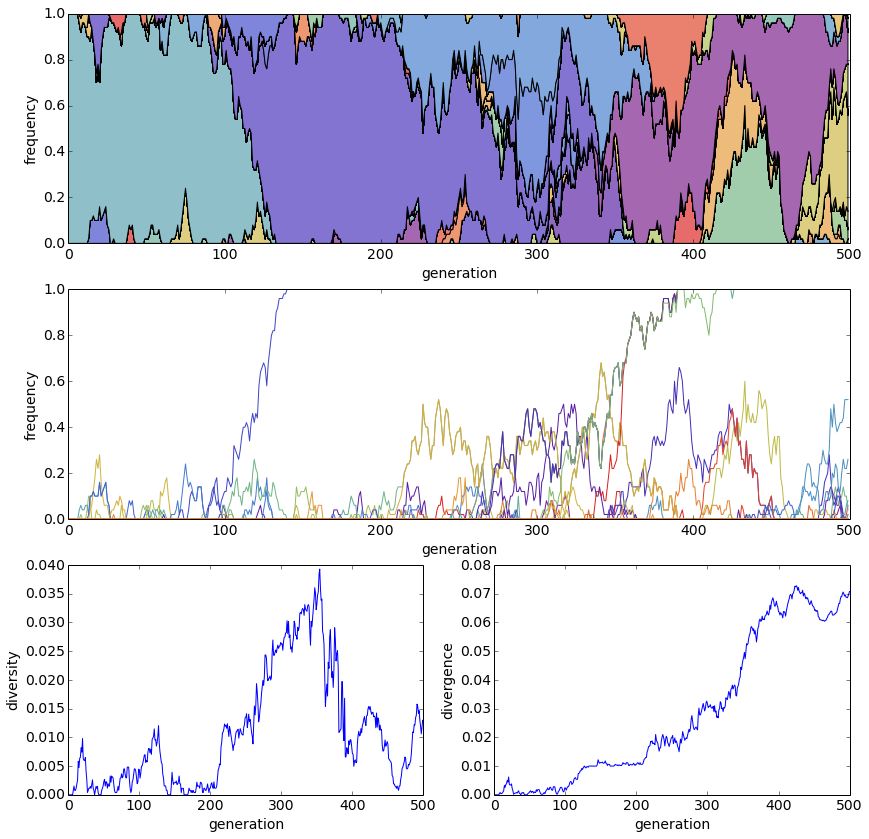

In [153]:
plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.subplot2grid((3,2), (0,0), colspan=2)
stacked_trajectory_plot()
plt.subplot2grid((3,2), (1,0), colspan=2)
snp_trajectory_plot()
plt.subplot2grid((3,2), (2,0))
diversity_plot()
plt.subplot2grid((3,2), (2,1))
divergence_plot()